In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
from prophet import Prophet #from prophet library import Prophet func.
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore") #Tells Python to suppress (hide) all warning messages to make outputs cleaner
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """ calculate MAPE given y_true and y_pred"""
    y_true, y_pred= np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true-y_pred/y_true))*100

In [29]:
pjme= pd.read_csv('PJME_hourly.csv',
                  index_col=[0], parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


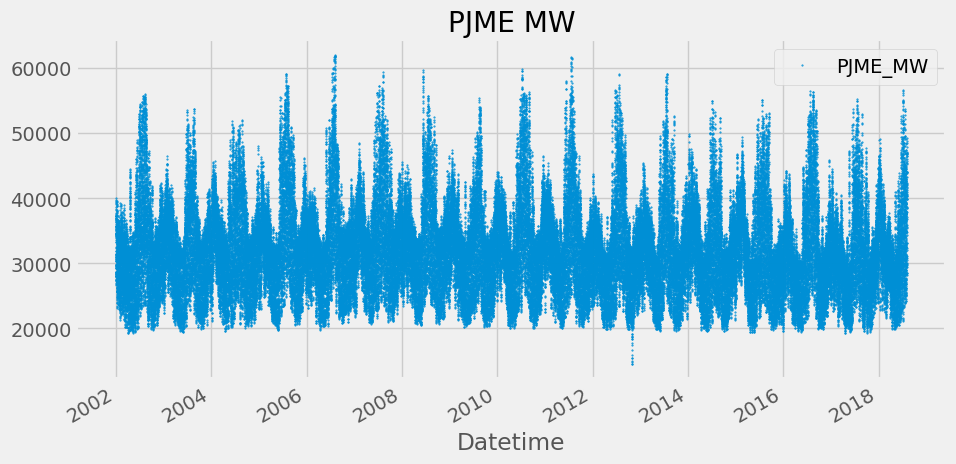

In [30]:
color_pal= sns.color_palette()
pjme.plot(style='.',
          figsize=(10,5),
          ms=1, #ms=marker size()
          color= color_pal[0],
          title="PJME MW")
plt.show()

In [ ]:
from pandas.api.types import CategoricalDtype

cat_type= CategoricalDtype(categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
                                       ordered=True)
def create_features(df, label=None):
    """Creates time series features from datetime index"""
    df=df.copy()
    df['date'] = df.index
    df['hour']= df['date'].dt.hour #integer 0–23 (useful for diurnal patterns in hourly data).
    #'.dt' is an accessor that works only on Series objects of datetime type — not on the whole DataFrame.
    df['dayofweek']= df['date'].dt.dayofweek #integer 0 (Monday) – 6 (Sunday). Good for numeric grouping or modelling.
    df['weekday']= df['date'].dt.day_name() #text name of weekday (Mon, Tue, …).
    df['weekday']= df['weekday'].astype(cat_type) #Then converted to the ordered categorical like 'cat_type'.
    df['quarter']= df['date'].dt.quarter #1–4 (useful for quarterly seasonality).
    df['month']= df['date'].dt.month #1–12 (monthly seasonality).
    df['year']= df['date'].dt.year #calendar year (useful for splitting or trend features).
    df['dayofyear']= df['date'].dt.dayofyear #1–365 (or 366) — good for Fourier or cyclical encoding of yearly seasonality.
    df['dayofmonths']= df['date'].dt.day #day number inside a month.
    df['weekofyear']= df['date'].dt.isocalendar().week #isocalendar().week gives ISO week number (1–52/53).
    
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300 #month*100 + day (e.g., March 21 → 3*100+21 = 321).
    #Subtracting 320 shifts the calendar so that March 21 becomes day 1 in this new scale.
    #% 1300 wraps the values so dates after year end map into the same numeric cycle (keeps the circle of year continuity b/w (0-1299) using modulo operations)

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']) 
    #buckets those numeric values of dates into 4 ranges and labels them Spring / Summer / Fall / Winter.
    #(0,300,602,900,1300) correspond to seasonal cut points in that shifted scale (they are chosen to approximate astronomical/meteorological boundaries around Mar21 / Jun20 / Sep22 / Dec20).

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonths', 'weekofyear', 'weekday',
            'season']] #'X'is the features DataFrame use for modeling. It includes both numeric and categorical features.
    if label:
        y = df[label]
        return X, y
    return X
# Example usage with a DataFrame `pjme` and a label column 'PJME_MW'
X, y = create_features(pjme, label='PJME_MW') # Extracts features (X) and target (y)
features_and_target = pd.concat([X, y], axis=1) #Combines them back into one DataFrame for inspection
#'axis=1'for Concatenate horizontally (side-by-side columns)

In [32]:
X.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonths,weekofyear,weekday,season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter


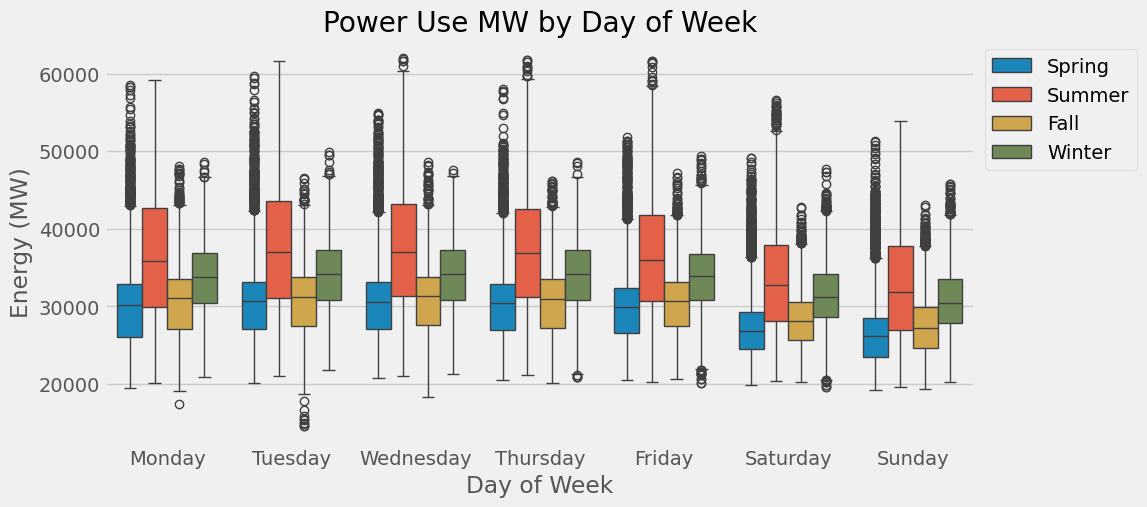

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1)) #'bbox_to_anchor=(1, 1)' controls the position of the legend box by taking coordinates.
plt.show()

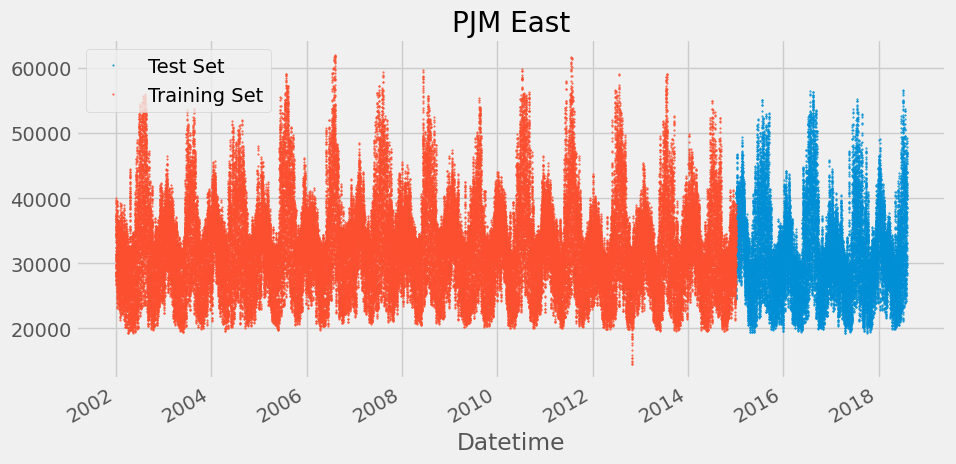

In [34]:
split_date= '1-Jan-2015'
pjme_train= pjme.loc[pjme.index<=split_date].copy()
pjme_test= pjme.loc[pjme.index>split_date].copy()

pjme_test\
    .rename(columns={'PJME_MW': 'Test Set'})\
    .join(pjme_train.rename(columns={'PJME_MW': 'Training Set'}),#to merge two dataframe side-by-side based on index or any common col, we can use .join() func.
          how='outer')\
    .plot(figsize=(10,5), title='PJM East', style='.', ms=1)
plt.show()

In [35]:
#Format data for prophet model using 'ds' col for datetime and 'y' for values
pjme_train_prophet= pjme_train.reset_index()\
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})
pjme_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [36]:
%%time
model= Prophet()
model.fit(pjme_train_prophet) #'%%time' measures and displays the execution time of an entire cell.Wall time: Total elapsed time (real-world clock time), CPU time: Actual CPU processing time (user + sys)

17:40:32 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 12 s
Wall time: 4min 4s


In [37]:
pjme_test_prophet= pjme_test.reset_index()\
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW':'y'})
pjme_test_prophet.head()

,ds,y
0,2015-12-31 01:00:00,24305.0
1,2015-12-31 02:00:00,23156.0
2,2015-12-31 03:00:00,22514.0
3,2015-12-31 04:00:00,22330.0
4,2015-12-31 05:00:00,22773.0


In [38]:
pjme_test_fcst= model.predict(pjme_test_prophet)
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31214.538782,23878.529538,32858.799320,31214.538782,31214.538782,-2835.415278,-2835.415278,-2835.415278,-4430.358409,...,1281.391449,1281.391449,1281.391449,313.551682,313.551682,313.551682,0.0,0.0,0.0,28379.123504
1,2015-01-01 02:00:00,31214.501664,22331.874238,31395.771307,31214.501664,31214.501664,-4339.786399,-4339.786399,-4339.786399,-5927.272155,...,1272.633421,1272.633421,1272.633421,314.852335,314.852335,314.852335,0.0,0.0,0.0,26874.715265
2,2015-01-01 03:00:00,31214.464546,21536.424313,30463.429660,31214.464546,31214.464546,-5211.482223,-5211.482223,-5211.482223,-6790.346307,...,1262.669605,1262.669605,1262.669605,316.194479,316.194479,316.194479,0.0,0.0,0.0,26002.982324
3,2015-01-01 04:00:00,31214.427428,21602.253146,30303.193934,31214.427428,31214.427428,-5353.035425,-5353.035425,-5353.035425,-6922.237166,...,1251.623600,1251.623600,1251.623600,317.578141,317.578141,317.578141,0.0,0.0,0.0,25861.392004
4,2015-01-01 05:00:00,31214.390310,21850.300353,30455.721521,31214.390310,31214.390310,-4678.699109,-4678.699109,-4678.699109,-6237.333672,...,1239.631218,1239.631218,1239.631218,319.003345,319.003345,319.003345,0.0,0.0,0.0,26535.691201


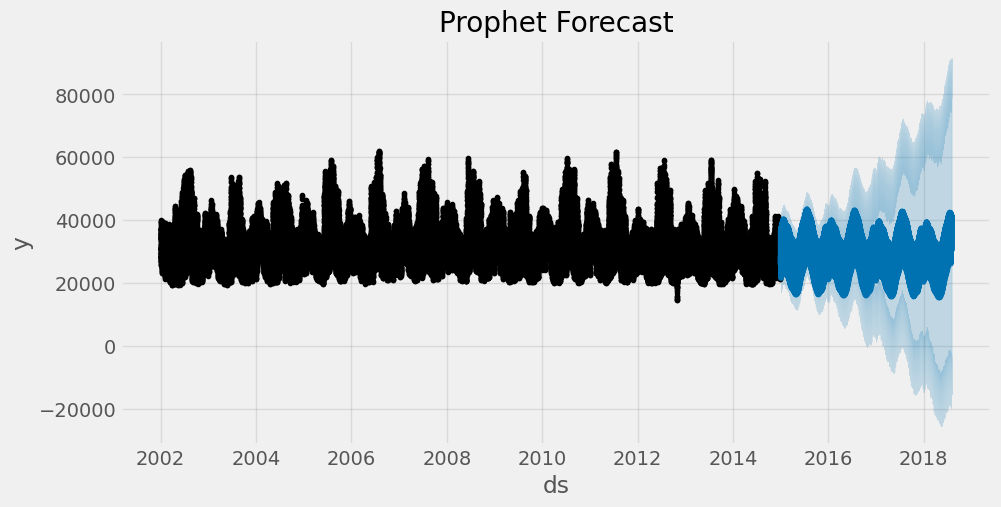

In [39]:
fig, ax=plt.subplots(figsize=(10,5))
fig= model.plot(pjme_test_fcst, ax=ax) #Prophet has its own built-in plotting function(that's why 'model.plot')
ax.set_title('Prophet Forecast')
plt.show()

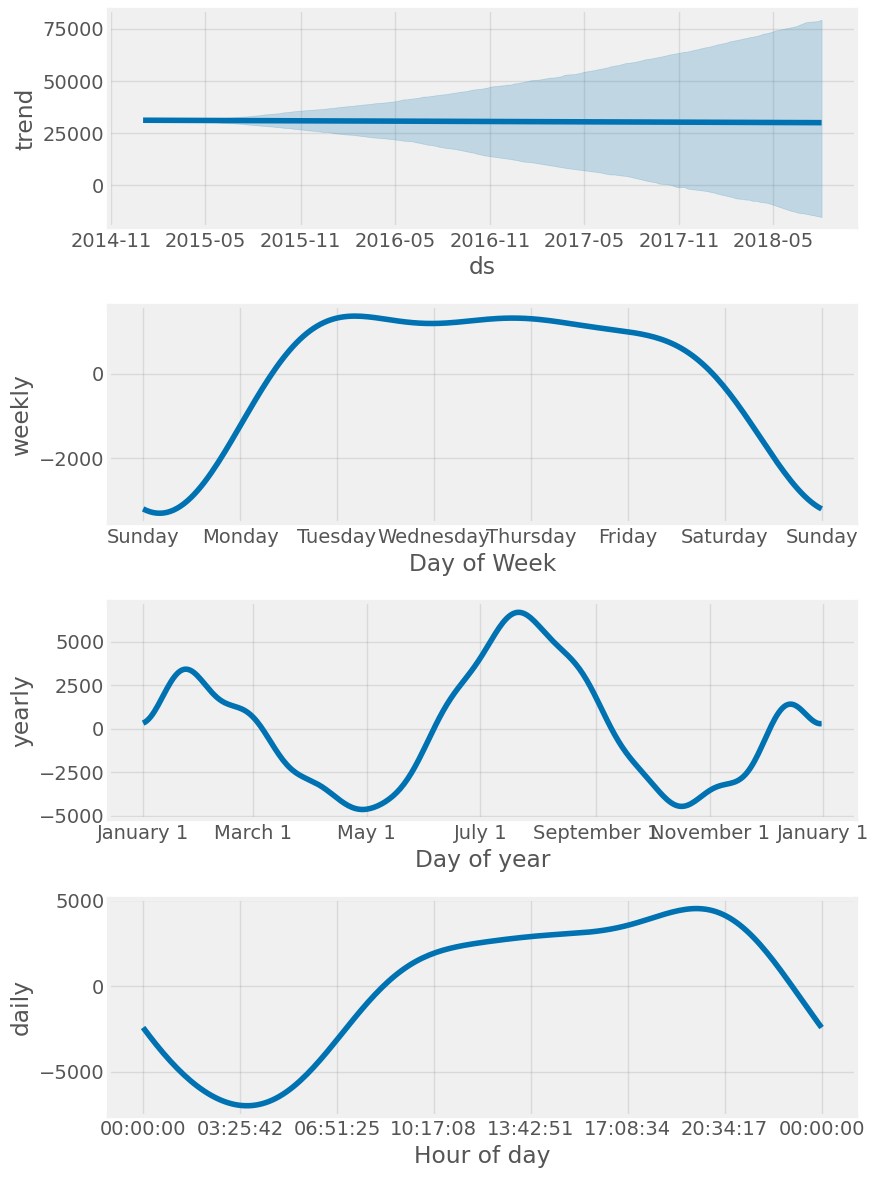

In [40]:
fig= model.plot_components(pjme_test_fcst)
plt.show()

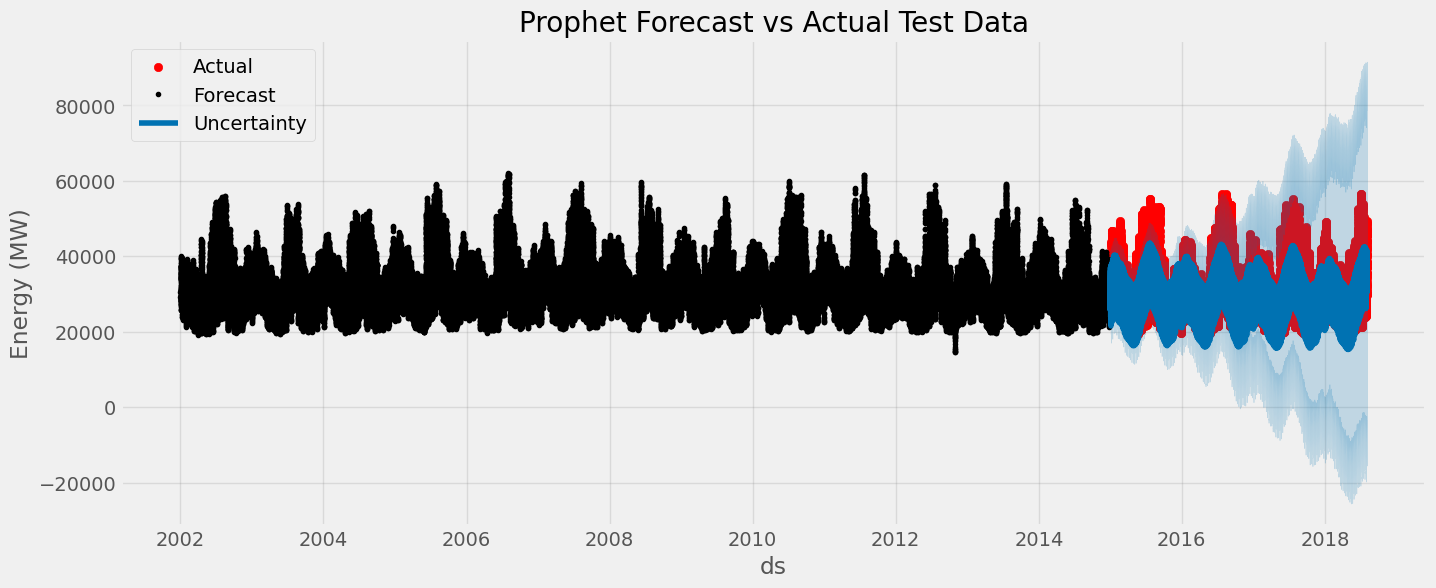

In [41]:
#compare actual to prediction
fig, ax= plt.subplots(figsize=(15,6))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig= model.plot(pjme_test_fcst, ax=ax)
plt.title('Prophet Forecast vs Actual Test Data')
plt.ylabel('Energy (MW)')
plt.legend(['Actual', 'Forecast', 'Uncertainty'])
plt.show()

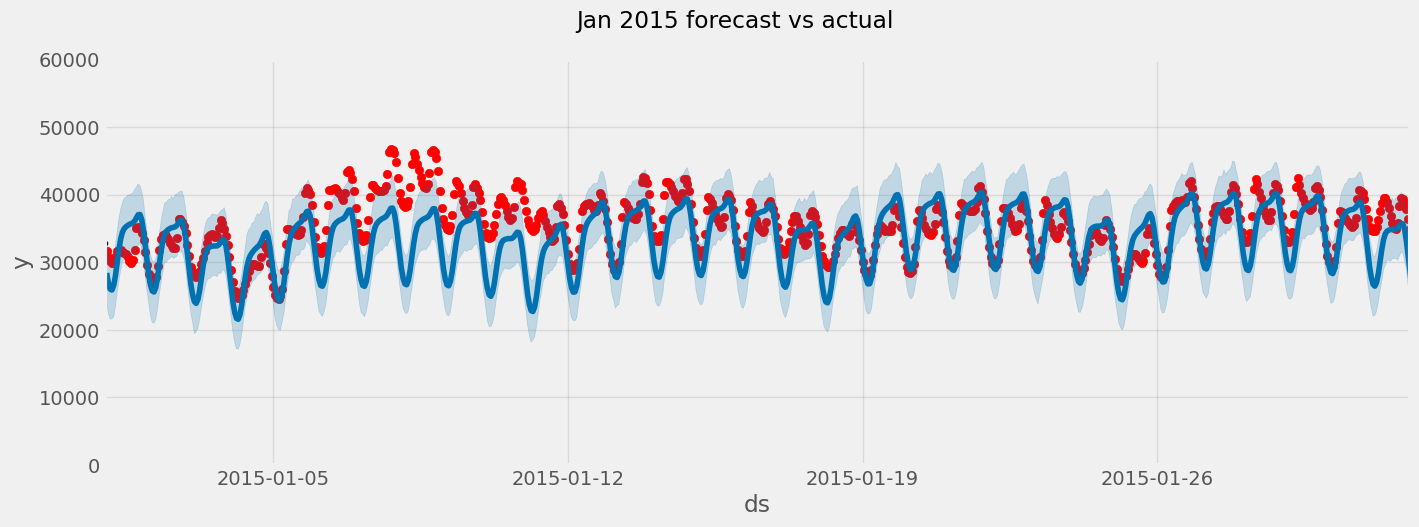

In [42]:
#To visualize the actual electricity demand values vs the forecasted values from Prophet for January 2015, with controlled axis limits and a clear comparison plot.

fig, ax= plt.subplots(figsize=(15,5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig= model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.Timestamp('2015-01-01'),# Set x-axis bounds using 'pd.Timestamp()' to convert date strings to datetime objects(represents a specific point in time)
              upper=pd.Timestamp('2015-02-01')) #'set_xbound()' to set upper and lowerbounds of x-axis
ax.set_ylim(0,60000) #set visual limits of y-axis on plot
plot= plt.suptitle('Jan 2015 forecast vs actual')
plt.show()

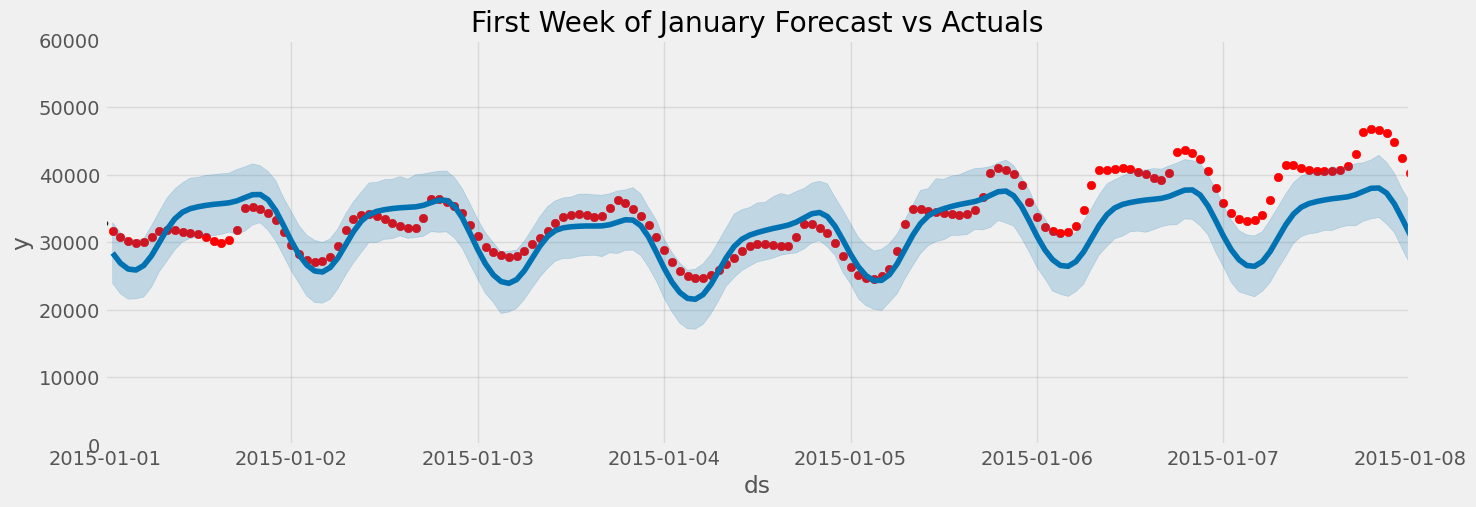

In [43]:
#for the first week of jan 2015
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
# Set x-axis bounds using pd.Timestamp to convert date strings to datetime objects
ax.set_xbound(lower=pd.Timestamp('2015-01-01'), upper=pd.Timestamp('2015-01-08'))
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

In [44]:
#sqrt of mean squared error
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcst['yhat']))


np.float64(6614.457352609915)

In [45]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst['yhat'])

5181.446012054891

In [46]:
mape= mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst['yhat'])
print("MAPE:", mape*100) #multiply 100 to show %

MAPE: 313215693.6306192


Future Predictions

In [47]:
future= model.make_future_dataframe(periods=2000*24, freq='h', include_history=False) #just creates dataframe of timestamps where freq is hourly for next 48000 hours(apprx 5.5 years)
forecast= model.predict(future)

In [48]:
future.head()

,ds
0,2015-01-01 01:00:00
1,2015-01-01 02:00:00
2,2015-01-01 03:00:00
3,2015-01-01 04:00:00
4,2015-01-01 05:00:00


In [49]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31214.538782,24146.014089,32778.417816,31214.538782,31214.538782,-2835.415278,-2835.415278,-2835.415278,-4430.358409,...,1281.391449,1281.391449,1281.391449,313.551682,313.551682,313.551682,0.0,0.0,0.0,28379.123504
1,2015-01-01 02:00:00,31214.501664,22582.569505,31377.393729,31214.501664,31214.501664,-4339.786399,-4339.786399,-4339.786399,-5927.272155,...,1272.633421,1272.633421,1272.633421,314.852335,314.852335,314.852335,0.0,0.0,0.0,26874.715265
2,2015-01-01 03:00:00,31214.464546,21373.413133,30532.075111,31214.464546,31214.464546,-5211.482223,-5211.482223,-5211.482223,-6790.346307,...,1262.669605,1262.669605,1262.669605,316.194479,316.194479,316.194479,0.0,0.0,0.0,26002.982324
3,2015-01-01 04:00:00,31214.427428,21370.296666,30501.843712,31214.427428,31214.427428,-5353.035425,-5353.035425,-5353.035425,-6922.237166,...,1251.623600,1251.623600,1251.623600,317.578141,317.578141,317.578141,0.0,0.0,0.0,25861.392004
4,2015-01-01 05:00:00,31214.390310,22273.661095,30878.810178,31214.390310,31214.390310,-4678.699109,-4678.699109,-4678.699109,-6237.333672,...,1239.631218,1239.631218,1239.631218,319.003345,319.003345,319.003345,0.0,0.0,0.0,26535.691201


In [50]:
forecast[['ds','yhat']].tail()

,ds,yhat
47995,2020-06-22 20:00:00,37952.136915
47996,2020-06-22 21:00:00,37248.419450
47997,2020-06-22 22:00:00,35681.226413
47998,2020-06-22 23:00:00,33528.994725
47999,2020-06-23 00:00:00,31253.050560


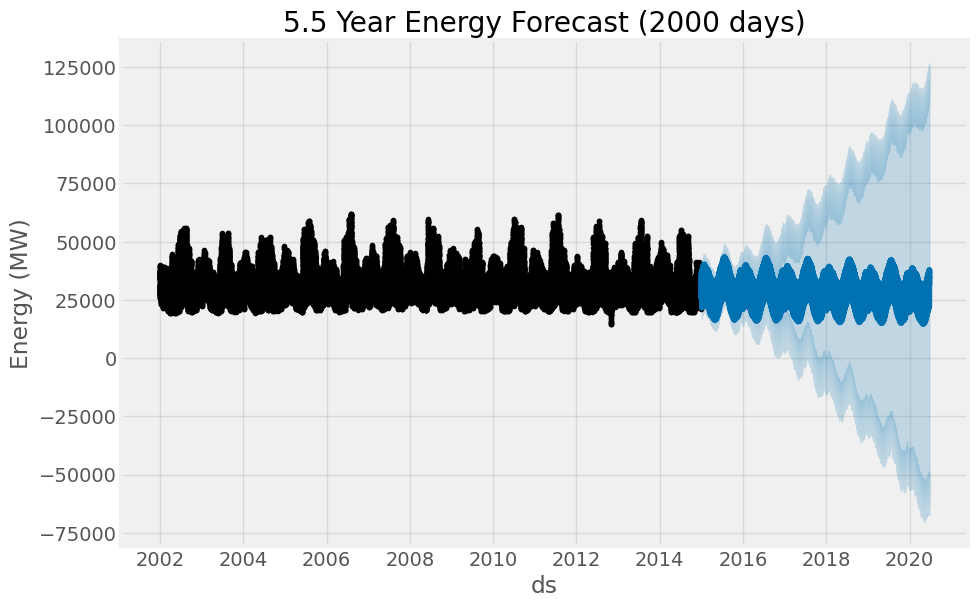

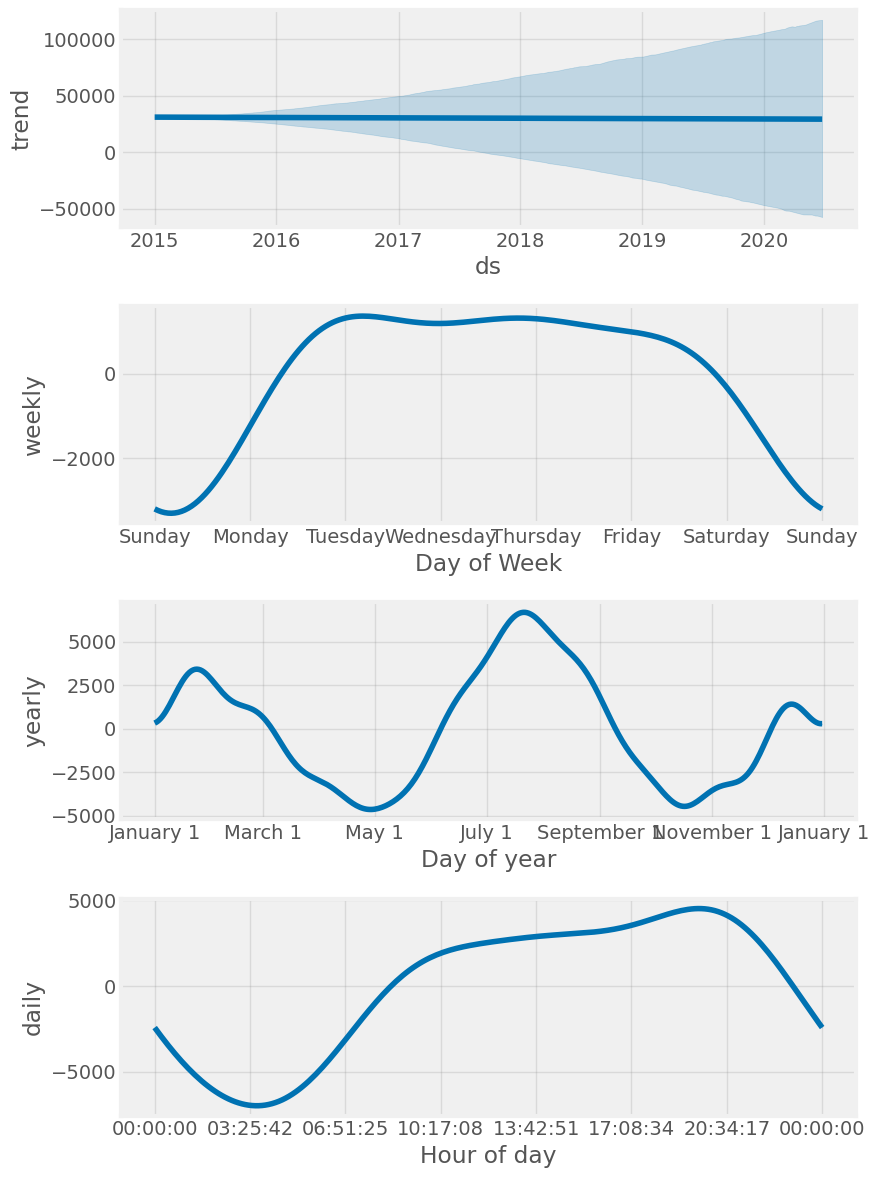

In [51]:
# Plot the long-term forecast
fig = model.plot(forecast)
plt.title('5.5 Year Energy Forecast (2000 days)')
plt.ylabel('Energy (MW)')
plt.show()

# Plot components
fig = model.plot_components(forecast)
plt.show()

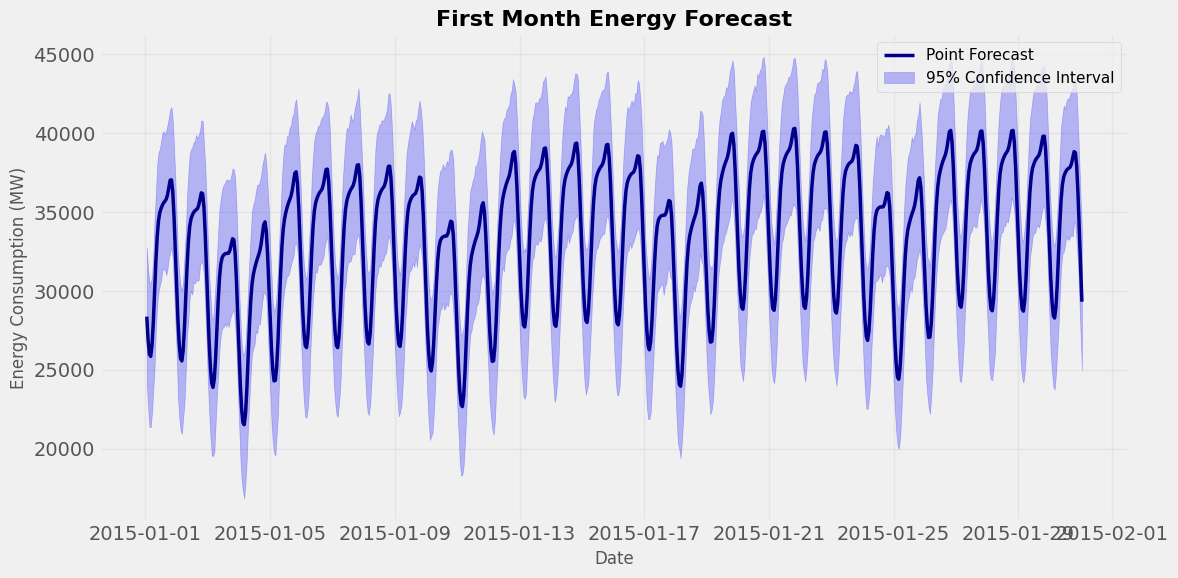

In [52]:
#Vsualize the first month of Prophet's forecast with uncertainty bands.

first_month= forecast[forecast['ds']<=forecast['ds'].min()+pd.Timedelta(days=30)]
fig, ax= plt.subplots(figsize=(12,6))
ax.plot(first_month['ds'], first_month['yhat'], 
        color='darkblue', linewidth=2.5, label='Point Forecast', zorder=3) #'zorder='controls the drawring order of elements (managing visual hierarchy when multiple elements overlap)
#Artists with higher zorder values are drawn on top of those with lower values.

ax.fill_between(first_month['ds'], 
                first_month['yhat_lower'], 
                first_month['yhat_upper'], 
                alpha=0.25, color='blue', 
                label='95% Confidence Interval', zorder=2)
ax.set_title('First Month Energy Forecast', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Energy Consumption (MW)', fontsize=12)
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()